In [1]:
import os
print(os.environ['LD_LIBRARY_PATH'])
os.environ['LD_LIBRARY_PATH']="/mnt/sw/nix/store/zi2wc26znf75csf5hhz77p0d2bbz53ih-cuda-11.8.0/lib64:$LD_LIBRARY_PATH"

import sys

import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cupy as cp
import lenspyx
import pysht
from pysht import get_geom
import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky

from mpl_toolkits.axes_grid1 import make_axes_locatable

lmax, mmax = 511, 511
# lmax, mmax = 2047, 2047
# lmax, mmax = 4095, 4095
ll = np.arange(0,lmax)
lldlm = np.arange(0,lmax+1024)
# geominfo = ('tgl',{'lmax': lmax, 'smax':3})
# geominfo = ('gl',{'lmax':lmax})
solver = 'shtns'
geominfo = ('gl',{'lmax':lmax}) # if solver == 'shtns' else ('cc',{'nphi':4116, 'ntheta':2056})
# geominfo = ('cc',{'nphi':1032, 'ntheta':2058})
# geominfo = ('healpix',{'nside': 512})

synunl = Xunl(lmax=lmax, geominfo=geominfo)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=geominfo)

philm = synunl.get_sim_phi(0, space='alm')
dlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))

Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
Tunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
Tskyalm = synsky.get_sim_sky(0, spin=0, space='alm', field='temperature')

/mnt/sw/nix/store/pmwk60bp5k4qr8vsg411p7vzhr502d83-openblas-0.3.23/lib:/cm/shared/apps/slurm/current/lib64
[SHTns 3.6.6] built Apr  4 2024, 19:17:02, id: v3.6.6-6-gd00ef3e*,avx512,ishioka,openmp,cuda
Could not import skcuda.fft
mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
INFO:: 04-06 18:08:28:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-06 18:08:28:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 04-06 18:08:28:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-06 18:08:28:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (131328,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(524288,)], types: [<class 'numpy.ndarray'>]
[ 0.00000000e+00+0.00000000e+00j  1.38034496e-04+0.00000000e+00j
  2.26476370e-04+0.00000000e

In [2]:
"""
gclm2lenmap
"""
deflection_kwargs = {
    'nthreads': 10,
    'dlm':dlm,
    'mmax_dlm':len(ll),
    'epsilon':1e-5,
    'verbosity':0,
    'single_prec':False,
    'planned':False}

defres = {}
for backend in ['CPU', "GPU"]:
    if backend == 'GPU':
        solvers = ['cufinufft']
        sht_solver = 'shtns' # 'shtns'
    elif backend == 'CPU':
        solvers = ['duccnufft']
        sht_solver = 'ducc' # 'shtns'

    for solver in solvers:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, geominfo, deflection_kwargs)

            print("\n----Testing function gclm2lenmap...----")
            if backend == 'GPU':
                defres.update({
                    backend: t.gclm2lenmap_cupy(
                        Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, mode=2)})
            else:
                defres.update({
                    backend: t.gclm2lenmap(
                        Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, mode=2)})

Testing solver=duccnufft backend=CPU mode=nuFFT...

----Testing function gclm2lenmap...----
Running in debug mode
ntheta:  525 nphihalf:  512 nphi:  1024 lmax_unl:  511 mmax:  511
- - - - - - - - - - - - - - - Timing setup: 0.224 seconds- - - - - - - - - - - - - - - 

CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (131328,)
  Output shape: [(524288,), (524288,)], types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
appending item
appending item
- - - - - - - - - - - - - - - Timing dlm2pointing: 0.002 seconds- - - - - - - - - - - - - - - 

CPU_DUCCnufft_transformer._synthesis
  Input shapes:
    self: ()
    gclm: (1, 131328)
    out: ()
  Output shape: [(1, 525, 1024)], types: [<class 'numpy.ndarray'>]
- - - - - - - - - - - - - - - Timing synthesis: 0.005 seconds- - - - - - - - - - - - - - - 

appending item
CPU_DUCCnufft_transformer._doubling
  Input shapes:
    self: ()
    map: (1, 525, 1024)
    ntheta: ()
    nphi: ()
    out: ()
  Output shape: [(1

/mnt/home/sbelkner/git/pySHT/pysht/deflection/GPU_nufft_transformer.py:234: RuntimeWarning: divide by zero encountered in divide
  scaled = hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


GPU_cufinufft_transformer._nuFFT
  Input shapes:
    self: ()
    fc: (2048, 2048)
    ptg_theta: (524288,)
    ptg_phi: (524288,)
    result: ()
  Output shape: [(524288,)], types: [<class 'cupy.ndarray'>]
- - - - - - - - - - - - - - - Timing nuFFT: 0.463 seconds- - - - - - - - - - - - - - - 

appending item
::debug:: Returned component results


In [3]:
defres['GPU'].keys(), defres['CPU'].keys()

(dict_keys(['spin-1 synth', 'pointing', 'dlm2pointing', 'synthesis', 'doubling', 'C2C', 'nuFFT']),
 dict_keys(['dlm2pointing', 'synthesis', 'doubling', 'C2C', 'nuFFT', 'rotate']))

'\nThis is synthesis onto CAR grid, currently not working for GPU as the CAR grid is not supported on GPU\n'

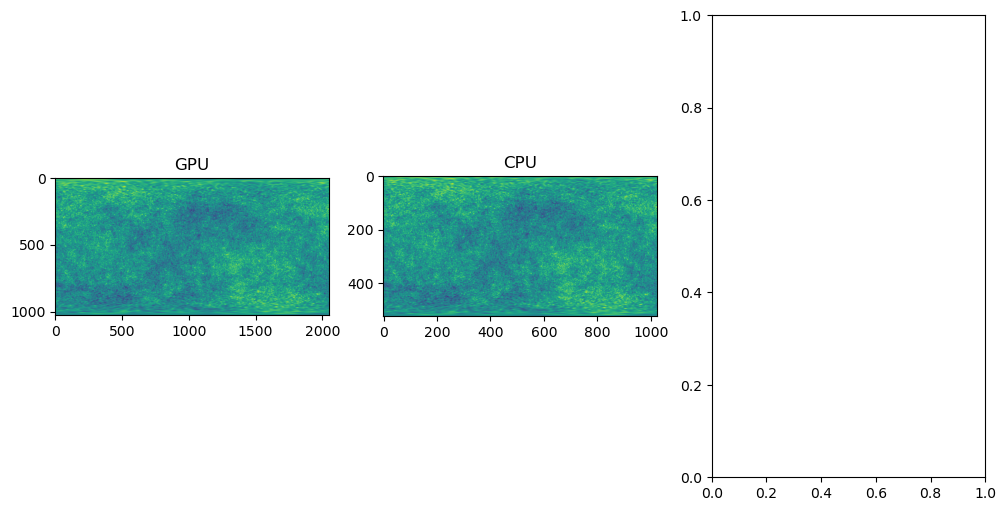

In [4]:
key = 'synthesis'
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].imshow(defres['GPU'][key][0].reshape(2048, 1024).T)
ax[0].set_title('GPU')
ax[1].imshow(defres['CPU'][key][0][0])
ax[1].set_title('CPU')
# ax[2].imshow(defres['CPU'][key][0]-defres['GPU'][key][0].reshape(geominfo_CAR[1]['nphi'], geominfo_CAR[1]['ntheta']).T)
# ax[2].set_title('CPU-GPU')

"""
This is synthesis onto CAR grid, currently not working for GPU as the CAR grid is not supported on GPU
"""


Text(0.5, 1.0, 'CPU')

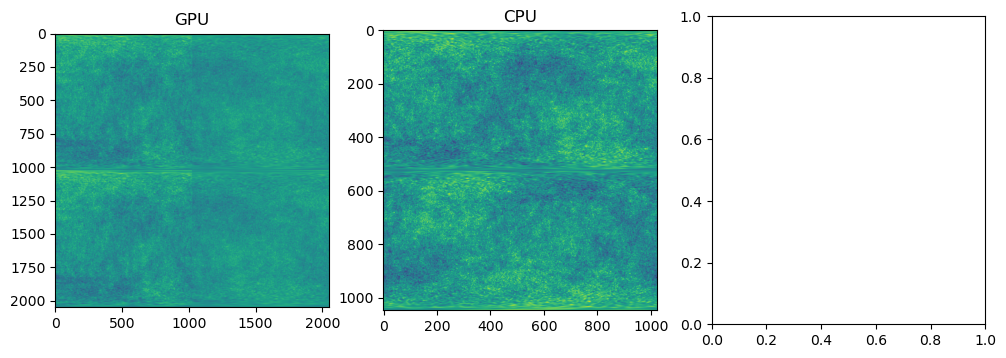

In [5]:
key = 'doubling'
fig, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].imshow(defres['GPU'][key][0].reshape(4*(lmax+1),-1).T)
ax[0].set_title('GPU')
ax[1].imshow(defres['CPU'][key][0])
ax[1].set_title('CPU')
# ax[2].imshow(defres['CPU'][key][:,1].reshape(-1,lmax+1).T)

(1, 4194304) (1, 1048, 1024)


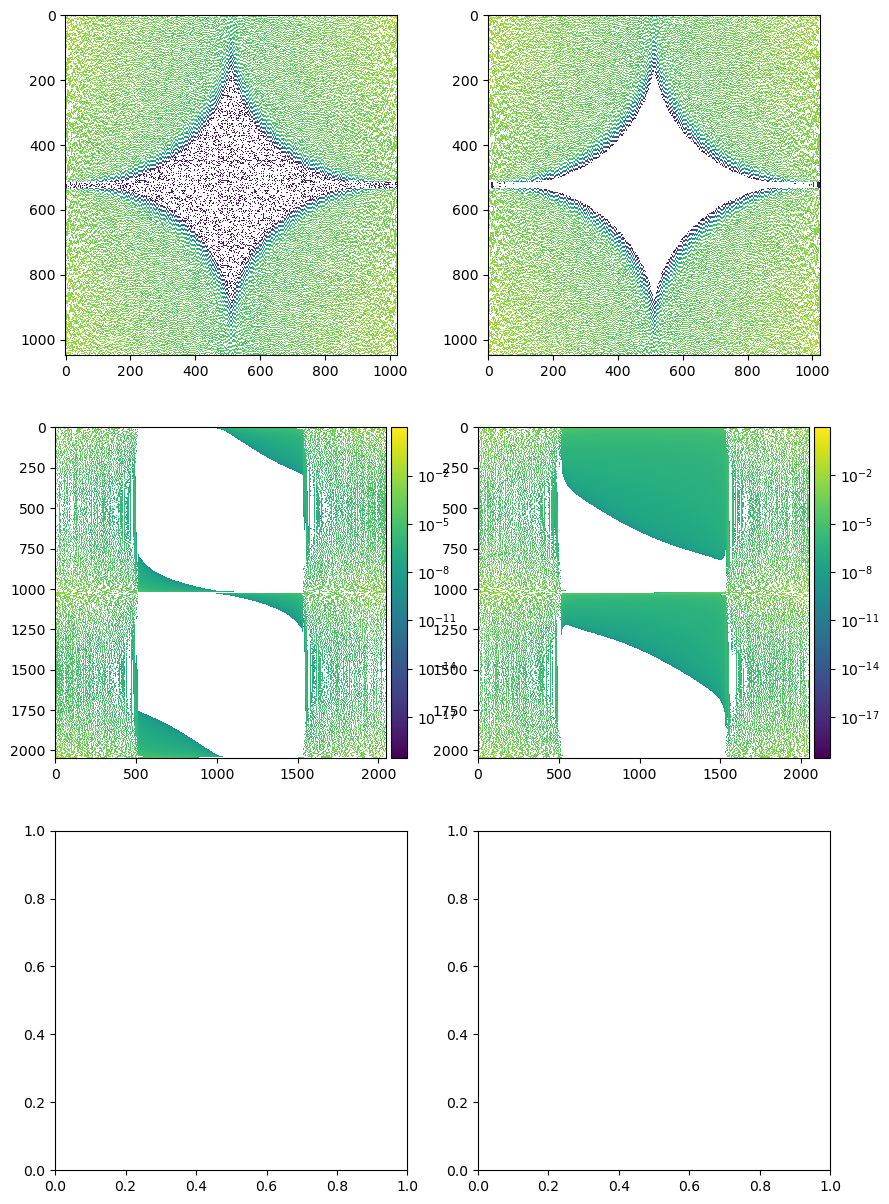

In [6]:
key = 'C2C'
print(defres['GPU'][key].shape, defres['CPU'][key].shape)

fig, ax = plt.subplots(3,2, figsize=(10,15))

ax[0,0].imshow(np.real(defres['CPU'][key][0]), norm='log')
ax[0,1].imshow(np.imag(defres['CPU'][key][0]), norm='log')

im = ax[1,0].imshow(np.real(defres['GPU'][key][0].reshape(-1,4*(lmax+1)).T), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(defres['GPU'][key][0].reshape(-1,4*(lmax+1)).T), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

# im = ax[2,0].imshow(defres['CPU'][key].real - defres['GPU'][key].reshape(lmax+1,-1).real, norm='log')
# divider = make_axes_locatable(ax[2,0])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')

# im = ax[2,1].imshow(defres['CPU'][key].imag - defres['GPU'][key].reshape(lmax+1,-1).imag, norm='log')
# divider = make_axes_locatable(ax[2,1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')

(2, 524288) (524288, 2)


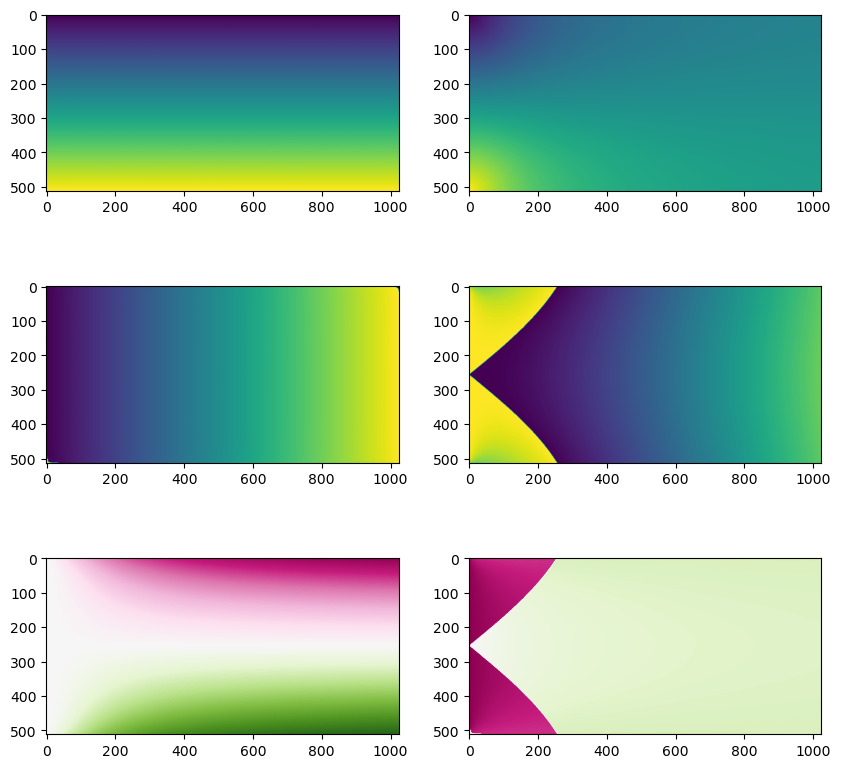

In [61]:
key = 'pointing'
print(defres['GPU'][key].shape, defres['CPU'][key].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][key][:,0].reshape(lmax+1,-1))
ax[0,1].imshow(defres['GPU'][key].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][key][:,1].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][key].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][key][:,0].reshape(lmax+1,-1) - defres['GPU'][key].T[:,0].reshape(lmax+1,-1), cmap='PiYG')
ax[2,1].imshow(defres['CPU'][key][:,1].reshape(lmax+1,-1) - defres['GPU'][key].T[:,1].reshape(lmax+1,-1), cmap='PiYG')

(1, 524288) (1, 524288)


"differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'\n"

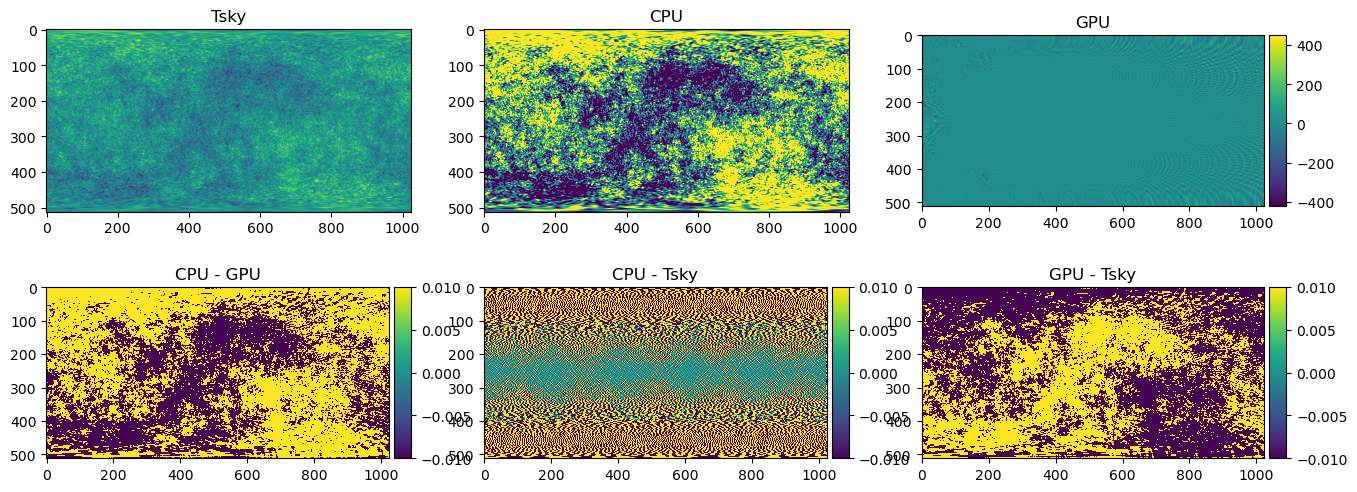

In [7]:
key = 'nuFFT'
print(defres['GPU'][key].shape, defres['CPU'][key].shape)

resCPU = defres['CPU'][key].real
resGPU = np.real(defres['GPU'][key][0])

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1).real)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=-1e2, vmax=1e2)
ax[0,1].set_title('CPU')


im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1))
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow((resCPU.reshape(lmax+1,-1)-resGPU.reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow((resCPU.reshape(lmax+1,-1)-Tsky.reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
ax[1,1].set_title('CPU - Tsky')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow((resGPU.reshape(lmax+1,-1)-Tsky.reshape(lmax+1,-1).real), vmin=-1e-2, vmax=1e-2)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('GPU - Tsky')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


"""differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'
"""

In [8]:
defres['CPU'][key][0].real

array([189.1774247 , 189.01910193, 188.85631011, ..., -60.96845839,
       -60.850749  , -60.73661629])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# This is for testing rotation later
for k in defres:
    print(k, defres[k][4].shape)
    print('-'*10)
fig, ax = plt.subplots(4,1, figsize=(10,12))

ax[0].imshow(Tsky.reshape(2048,-1).real)
ax[1].imshow(defres['CPU'][key].reshape(2048,-1))

im = ax[2].imshow(defres['CPU'][key].reshape(2048,-1))
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[3].imshow((defres['CPU'][key].reshape(2048,-1)-defres['CPU'][key].reshape(2048,-1)))#, vmin=-1e-1, vmax=1e-1)
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
solver, mode, backend = 'ducc', 'SHT', 'CPU'     
print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
tDCPU = pysht.get_transformer(solver, mode, backend)
tDCPU = tDCPU(geominfo)

solver, mode, backend = 'shtns', 'SHT', 'CPU'  
print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
tSCPU = pysht.get_transformer(solver, mode, backend)
tSCPU = tSCPU(geominfo)

solver, mode, backend = 'shtns', 'SHT', 'GPU'  
print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
tSGPU = pysht.get_transformer(solver, mode, backend)
tSGPU = tSGPU(geominfo)

In [ ]:
print(tDCPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).shape)
print(tSCPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).shape)
print(tSGPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).shape)

In [ ]:
plt.imshow(tDCPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).reshape(lmax+1,-1))
plt.show()
plt.imshow(tSCPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).reshape(lmax+1,-1))
plt.show()
plt.imshow(tSGPU.synthesis(Tunl, lmax=lmax, mmax=mmax, spin=0, nthreads=4).reshape(2*(lmax+1),-1).T)
plt.show()
plt.imshow(tSGPU.constructor.synth(Tunl).T)

In [ ]:
plt.imshow(tSGPU.constructor.synth(Tunl))

In [ ]:
plt.imshow(np.arange(0,50).reshape(10,5))
plt.colorbar()

In [ ]:
import shtns
geominfo_cc = ('cc',{'nphi':2*(2047+1), 'ntheta':2047+1})
c = shtns.sht(int(geominfo_cc[1]['ntheta']-1), int(geominfo_cc[1]['ntheta']-1))
c.set_grid(flags=shtns.sht_reg_dct + shtns.SHT_THETA_CONTIGUOUS)

In [ ]:
import shtns
import pysht.geometry as geometry
import ducc0
ntheta = ducc0.fft.good_size(2500 + 2)
nphihalf = ducc0.fft.good_size(2500 + 1)
nphi = 2 * nphihalf
print(ntheta, nphi)

import shtns
lmax = 2047
constructor = shtns.sht(int(lmax), int(lmax))
ntheta, nphi = 2520, 5040
constructor.set_grid(flags=shtns.SHT_ALLOW_GPU + shtns.sht_reg_poles + shtns.SHT_THETA_CONTIGUOUS, nlat=ntheta, nphi=nphi)


import ducc0
import healpy as hp
import numpy as np

lmax, mmax = 1024, 1024
toylm = np.random.randn(hp.Alm.getsize(lmax, lmax)) + 1j* np.random.randn(hp.Alm.getsize(lmax, lmax))
gclm = np.atleast_2d(toylm)

ntheta = ducc0.fft.good_size(lmax + 2)
nphihalf = ducc0.fft.good_size(lmax + 1)
nphi = 2 * nphihalf
map = ducc0.sht.experimental.synthesis_2d(
    alm=gclm,
    ntheta=ntheta,
    nphi=nphi,
    spin=0,
    lmax=lmax,
    mmax=mmax, geometry="CC",
    nthreads=10, mode="STANDARD")

print(map.shape, ntheta, nphi, dlm.shape)
        